In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

In [56]:
lim = 10
xvec = np.linspace(-1*lim,lim,100)
X, Y = np.meshgrid(xvec, xvec)
QFunc_instance =  qt.QFunc(xvec, xvec,2,memory=4096)

def get_q_value(state):
    q_values = QFunc_instance(state)
    return q_values

def plot_qfunc_cdf_contours(ax, q_values,levels = [0.001,0.5,0.99, 0.999],color='black'):
    sorted_q = np.sort(q_values.ravel())
    cumulative_sum = np.cumsum(sorted_q)
    total_sum = cumulative_sum[-1]
    for prob in levels:
        alpha = np.sqrt(1-prob)
        
        level_value = sorted_q[np.argmax(cumulative_sum >= total_sum * (1 - prob))]
        # fmt = {level_value:f'{1 - prob:.2f}'}   
        contour = ax.contour(X, Y, q_values, levels=[level_value], colors=color,alpha=alpha)
        # ax.clabel(contour, inline=False, fontsize=8, fmt=fmt,colors='black') 

In [57]:
def alpha_analytical(t, Delta_rd, epsilon_r, kappa):
    return (-1j*epsilon_r / (1j*Delta_rd + kappa/2)) * (1 - np.exp(-(1j*Delta_rd + kappa/2)*t))

In [47]:
omega_r = 2 * np.pi * 5.0
omega_d = 2 * np.pi * 4.998
omega_amp = 2 * np.pi * 0.01
kappa = 0.005

N = 200

a = qt.destroy(N)

delta = omega_r - omega_d
H_res = delta * a.dag() * a
H_drive = omega_amp * (a + a.dag())

H = H_res + H_drive
tlist = np.linspace(0, 600, 600)
result = qt.mesolve(H = H, 
                    rho0 = qt.fock(N, 0), 
                    tlist = tlist, 
                    c_ops  = [np.sqrt(kappa) * a], 
                    e_ops = [a,a.dag() * a],
                    progress_bar=True,
                    options=qt.solver.Options(store_states=True)
                    )

10.0%. Run time:   0.25s. Est. time left: 00:00:00:02
20.0%. Run time:   0.95s. Est. time left: 00:00:00:03
30.0%. Run time:   2.09s. Est. time left: 00:00:00:04
40.0%. Run time:   3.27s. Est. time left: 00:00:00:04
50.0%. Run time:   4.49s. Est. time left: 00:00:00:04
60.0%. Run time:   5.71s. Est. time left: 00:00:00:03
70.0%. Run time:   6.96s. Est. time left: 00:00:00:02
80.0%. Run time:   8.27s. Est. time left: 00:00:00:02
90.0%. Run time:   9.67s. Est. time left: 00:00:00:01
Total run time:  10.99s


(-10.0, 10.0)

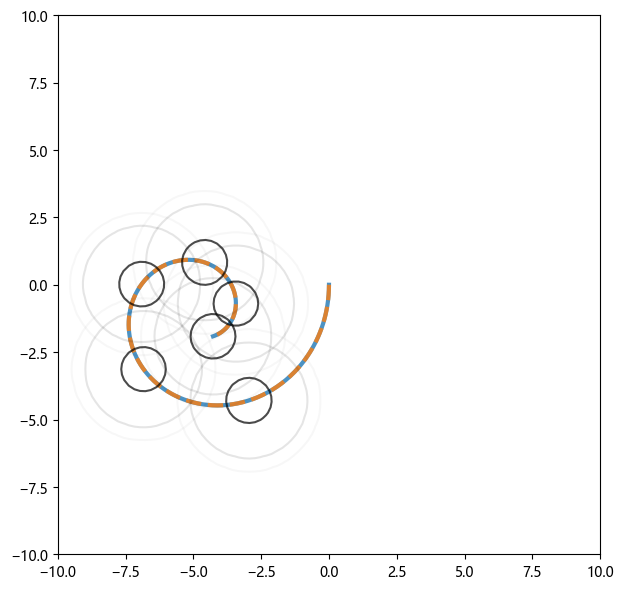

In [58]:
fig,ax = plt.subplots(1,1,figsize=(7,7))

alpha = result.expect[0]
ax.plot(alpha.real,alpha.imag,alpha = 0.8,linewidth = 3)

alpha_semi_c = alpha_analytical(tlist, delta, omega_amp, kappa)
ax.plot(alpha_semi_c.real,alpha_semi_c.imag,alpha = 0.8,linewidth = 3,linestyle='--')


for t_idx in [100,200,300,400,500,599]:
    q_vals =  get_q_value(result.states[t_idx])
    plot_qfunc_cdf_contours(ax, q_vals)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)